In [24]:
import pandas as pd
import numpy as np
from numba import njit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from itertools import combinations
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

In [35]:
ratings_df = pd.read_csv('data/ratings.dat', sep='::', names=["userId", "movieId", "rating", "timestamp"],  engine='python')
ratings_df.drop('timestamp', axis=1, inplace=True)

In [3]:
def split_train_test(ratings_df, test_size=0.3, min_ratings=10, seed=42):
    train_list = []
    test_list = []

    for user_id, group in ratings_df.groupby('userId'):
        if len(group) < min_ratings:
            continue  

        train_grp, test_grp = train_test_split(group, test_size=test_size, random_state=seed)
        train_list.append(train_grp)
        test_list.append(test_grp)

    train_df = pd.concat(train_list)
    test_df = pd.concat(test_list)

    common_movies = set(train_df['movieId']) & set(test_df['movieId'])
    train_df = train_df[train_df['movieId'].isin(common_movies)]
    test_df = test_df[test_df['movieId'].isin(common_movies)]
    
    return train_df, test_df

In [4]:
@njit
def cosine_similarity_overlap(u1, u2, normalize=True):
    mask = np.isfinite(u1) & np.isfinite(u2)  
    common_items = np.sum(mask)
    
    if common_items == 0:
        return -1 
    
    v1 = u1[mask]
    v2 = u2[mask]
    
    if normalize:
        v1 = (v1 - np.mean(v1)) / (np.std(v1) + 1e-10)
        v2 = (v2 - np.mean(v2)) / (np.std(v2) + 1e-10)
    
    numerator = np.dot(v1, v2)
    denominator = np.linalg.norm(v1) * np.linalg.norm(v2)
    
    return numerator / denominator if denominator != 0 else np.nan

In [5]:
train_df, test_df = split_train_test(ratings_df[:100000])

In [6]:
user_item_matrix = train_df.pivot(index='userId', columns='movieId', values='rating')
users = user_item_matrix.index
user_similarity_df = pd.DataFrame(index=users, columns=users, dtype=float)
total_pairs = len(users) * (len(users) - 1) // 2

for u1, u2 in tqdm(combinations(users, 2), total=total_pairs):
    sim = cosine_similarity_overlap(
        user_item_matrix.loc[u1].values,
        user_item_matrix.loc[u2].values
    )
    user_similarity_df.loc[u1, u2] = sim
    user_similarity_df.loc[u2, u1] = sim 

100%|███████████████████████████████████████████████████████████████████████| 223446/223446 [00:19<00:00, 11564.05it/s]


In [7]:
user_item_matrix.notna().sum().sum() / user_item_matrix.shape[0] / user_item_matrix.shape[1]

0.03774978437664196

In [8]:
def recommend_movies_for_user(user_id, user_item_matrix, user_similarity_df, top_k_users, top_n_movies):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:top_k_users+1]

    ratings = user_item_matrix.loc[similar_users.index]
    mean_ratings = ratings.mean(axis=1)
    normalized = ratings.sub(mean_ratings, axis=0)
    weighted = normalized.mul(similar_users, axis=0)

    sim_sums_per_movie = weighted.notna().mul(similar_users.abs(), axis=0).sum(axis=0)
    epsilon = 1
    weighted_avg = weighted.sum(axis=0) / (sim_sums_per_movie + epsilon)

    valid_movies = sim_sums_per_movie > 0
    weighted_avg = weighted_avg.where(valid_movies, 0)
    
    target_user_mean = user_item_matrix.loc[user_id].mean()
    weighted_avg += target_user_mean
    weighted_avg = weighted_avg.sort_values(ascending=False)

    unseen_movies = user_item_matrix.loc[user_id].isna()
    recommendations = weighted_avg[unseen_movies].clip(0.0, 5.0)

    return recommendations.head(top_n_movies)  

In [9]:
y_true = []
y_pred = []

test_user_groups = test_df.groupby('userId')
users_recs = defaultdict(list)

for user_id, user_test_data in tqdm(test_user_groups, total=test_df['userId'].nunique()):
    recs = recommend_movies_for_user(user_id, user_item_matrix, user_similarity_df, top_k_users=150, top_n_movies=100)
    users_recs[user_id] = recs.index.tolist()
    
    for movie_id in set(user_test_data['movieId']):
        if movie_id in recs.index:
            y_true.append(user_test_data[user_test_data['movieId'] == movie_id]['rating'].values[0])
            y_pred.append(recs[movie_id])

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.4f}")
print(f"Mean: {test_df['rating'].mean():.4f}")
print(f"Std: {test_df['rating'].std():.4f}")

100%|████████████████████████████████████████████████████████████████████████████████| 669/669 [00:07<00:00, 94.05it/s]

RMSE: 0.8618
Mean: 3.6231
Std: 1.1095


In [10]:
def precision_recall_at_k(df, users_recs, k_list, relevance_threshold=4):
    user_groups = df.groupby('userId')
    results = []
    
    for k in k_list:
        precision_list = []
        recall_list = []
        
        for user_id, user_data in user_groups:
            relevant_movies = set(user_data[user_data['rating'] >= relevance_threshold]['movieId'])
            recommended_k = set(users_recs[user_id][:k])
    
            hits = len(recommended_k & relevant_movies)
            
            precision = hits / k if k else 0
            recall =  hits / len(relevant_movies) if relevant_movies else 0
    
            precision_list.append(precision)
            recall_list.append(recall)
            
        results.append({'k': k, 'precision': np.mean(precision_list), 'recall': np.mean(recall_list)})

    return pd.DataFrame(results)

In [11]:
def precision_recall_plot(users_recs):
    k_values = [1, 3, 5, 10, 20, 50, 100]

    metrics_df = precision_recall_at_k(test_df, users_recs=users_recs, k_list=k_values)
    
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_df['k'], metrics_df['precision'], marker='o', label='Precision@k')
    plt.plot(metrics_df['k'], metrics_df['recall'], marker='s', label='Recall@k')
    plt.title('Precision@k и Recall@k по разным k')
    plt.xlabel('k')
    plt.ylabel('Метрика')
    plt.legend()
    plt.xticks(k_values)
    plt.show()
    

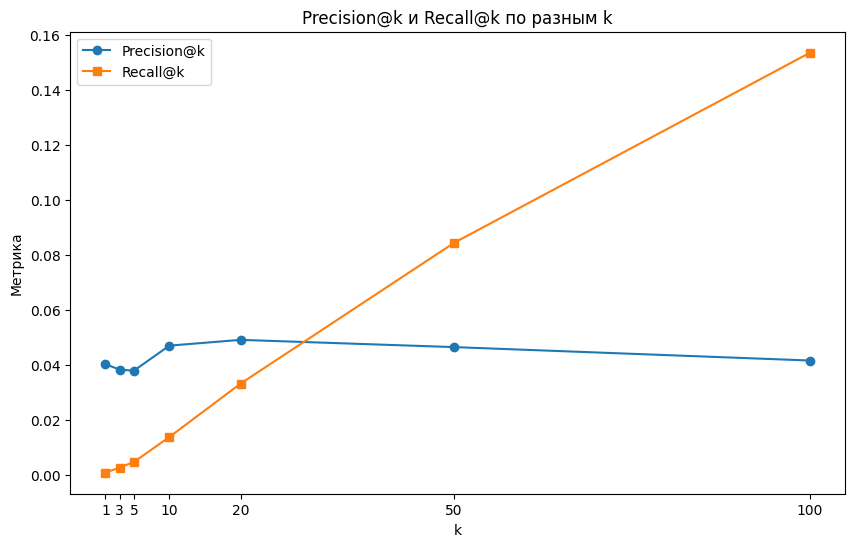

In [12]:
precision_recall_plot(users_recs)

In [13]:
from surprise import SVD
from surprise import accuracy
from surprise import Dataset, Reader

In [14]:
train_df, test_df = split_train_test(ratings_df)
reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
train_set = train_data.build_full_trainset()

In [15]:
params = {'n_factors': 10, 'lr_all': 0.03, 'reg_all': 0.02, 'n_epochs': 100}
model = SVD(**params)
model.fit(train_set)

predictions = model.test([tuple(x) for x in test_df[['userId', 'movieId', 'rating']].values])
rmse = accuracy.rmse(predictions)

RMSE: 0.8905


In [16]:
all_users = train_set.all_users()
all_items = train_set.all_items()

all_user_ids = [train_set.to_raw_uid(u) for u in all_users]
all_item_ids = [train_set.to_raw_iid(i) for i in all_items]

train_user_items = defaultdict(set)
for uid, iid, _ in train_set.all_ratings():
    train_user_items[train_set.to_raw_uid(uid)].add(train_set.to_raw_iid(iid))

testset_full = []
for uid in all_user_ids:
    seen = train_user_items[uid]
    unseen = [iid for iid in all_item_ids if iid not in seen]
    for iid in unseen:
        testset_full.append((uid, iid, 0)) 


In [17]:
predictions = model.test(testset_full)

top_n = defaultdict(list)
for uid, iid, true_r, est, _ in predictions:
    top_n[uid].append((iid, est))
for uid, user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    for i in range(100):
        top_n[uid][i] = user_ratings[i][0]

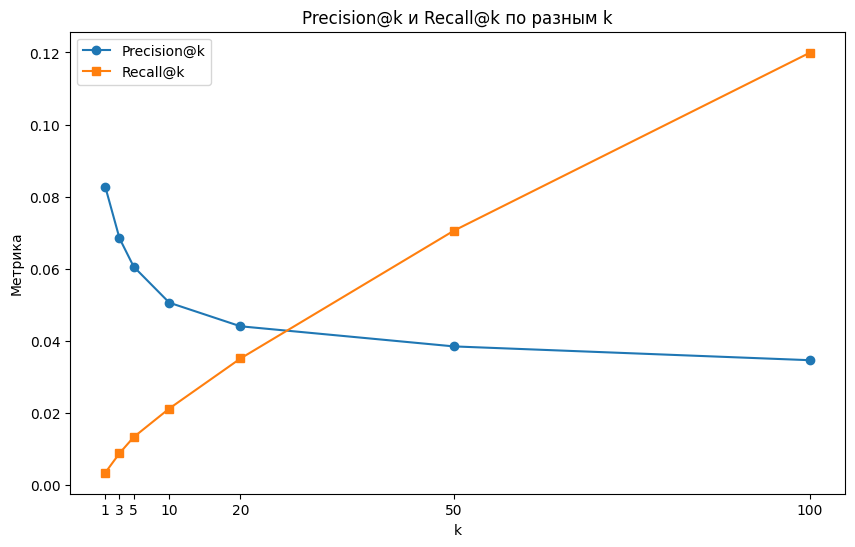

In [18]:
precision_recall_plot(top_n)

In [49]:
import implicit
from scipy.sparse import csr_matrix, save_npz, load_npz
import joblib

In [ ]:
user_item_matrix = csr_matrix((train_df['rating'], (train_df['userId'], train_df['movieId'])))

model = implicit.als.AlternatingLeastSquares(factors=50, iterations=300)
model.fit(user_item_matrix)

In [27]:
test_user_groups = test_df.groupby('userId')
users_recs = defaultdict(list)

for user_id, user_test_data in tqdm(test_user_groups, total=test_df['userId'].nunique()):
    recs = model.recommend(user_id, user_item_matrix[user_id], N=100)
    users_recs[user_id] = recs[0].tolist()

100%|████████████████████████████████████████████████████████████████████████████| 6040/6040 [00:00<00:00, 7271.02it/s]


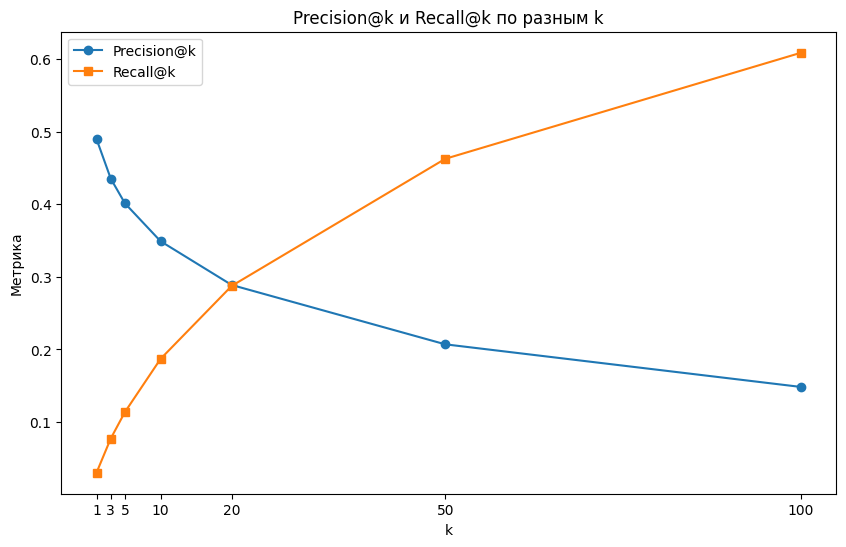

In [28]:
precision_recall_plot(users_recs)

In [50]:
joblib.dump(model, 'models/als_model.joblib')
save_npz('models/user_item_matrix.npz', user_item_matrix)